## Data Importing and Pre-processing

In [1]:
# import libraries needed
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.*")
%matplotlib inline

In [2]:
# read file and see number of rows and cols
nba_df = pd.read_csv("nba_2022-23_all_stats_with_salary.csv")
nba_df.shape

(467, 52)

In [3]:
nba_df.head()

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,0.493,4.9,11.4,0.427,5.1,8.8,0.579,0.614,4.6,5.0,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,1941,24.1,0.656,0.564,0.248,2.3,16.8,9.7,30.0,1.3,0.9,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,0.408,1.0,3.2,0.303,3.1,6.7,0.459,0.457,2.3,3.3,0.681,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,755,13.6,0.498,0.322,0.334,2.1,11.4,6.8,35.3,1.8,1.4,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,0.436,1.2,3.9,0.311,4.7,9.7,0.487,0.481,2.8,4.3,0.656,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,2126,16.1,0.513,0.289,0.317,4.7,16.5,10.8,38.6,1.7,1.3,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,0.500,2.2,6.9,0.321,8.9,15.3,0.580,0.549,4.6,5.9,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,1954,23.9,0.583,0.309,0.268,3.7,20.8,12.5,33.5,1.2,1.4,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,0.560,2.0,4.9,0.404,8.3,13.4,0.617,0.614,6.5,7.1,0.919,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,1672,25.9,0.677,0.267,0.387,1.2,19.5,10.5,24.5,1.0,3.4,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [4]:
# reanme 'Unnamed: 0' column to 'ID'
nba_df = nba_df.rename(columns={"Unnamed: 0": "Id"})

In [5]:
# Remove spaces from column names
nba_df.columns = [col.replace(" ", "") for col in nba_df.columns]

In [6]:
# count number of categorical variables
category_count = 0

for cat in nba_df.dtypes:
    if cat == "object":
        category_count += 1

In [7]:
print("Number of categorical variables:", category_count)

# column 1 is the ID column so we subract 1
numeric_count = nba_df.shape[1] - category_count - 1

print("Number of contineous variables:", numeric_count)

Number of categorical variables: 3
Number of contineous variables: 48


In [8]:
# see all the column names
nba_df.columns

Index(['Id', 'PlayerName', 'Salary', 'Position', 'Age', 'Team', 'GP', 'GS',
       'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'TotalMinutes', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'],
      dtype='object')

### Handling our missing data

In [9]:
# display the missing data and its percent of the column
total_missing = nba_df.isnull().sum().sort_values(ascending=False)
percent_missing = (nba_df.isnull().sum() / nba_df.isnull().count()).sort_values(ascending=False)

missing_data_df = pd.concat([total_missing, percent_missing], axis=1, keys=["Total Missing", "Percent Missing"])
missing_data_df.head(8)

,Total Missing,Percent Missing
FT%,23,0.049251
3P%,13,0.027837
2P%,4,0.008565
TS%,1,0.002141
3PAr,1,0.002141
FTr,1,0.002141
eFG%,1,0.002141
FG%,1,0.002141


In [10]:
# example row of a player who has missing data
# players with missing data are those who did not play many games so they never accumilated that stat during the season
null_fg = nba_df[nba_df['FG%'].isnull()]
null_fg

,Id,PlayerName,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
436,436,Alondes Williams,254446,SG,23,BRK,1,0,5.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,5,-20.9,NaN,NaN,NaN,0.0,22.0,11.2,0.0,0.0,0.0,100.0,17.7,-0.1,0.0,-0.1,-0.517,-21.3,-5.2,-26.5,0.0


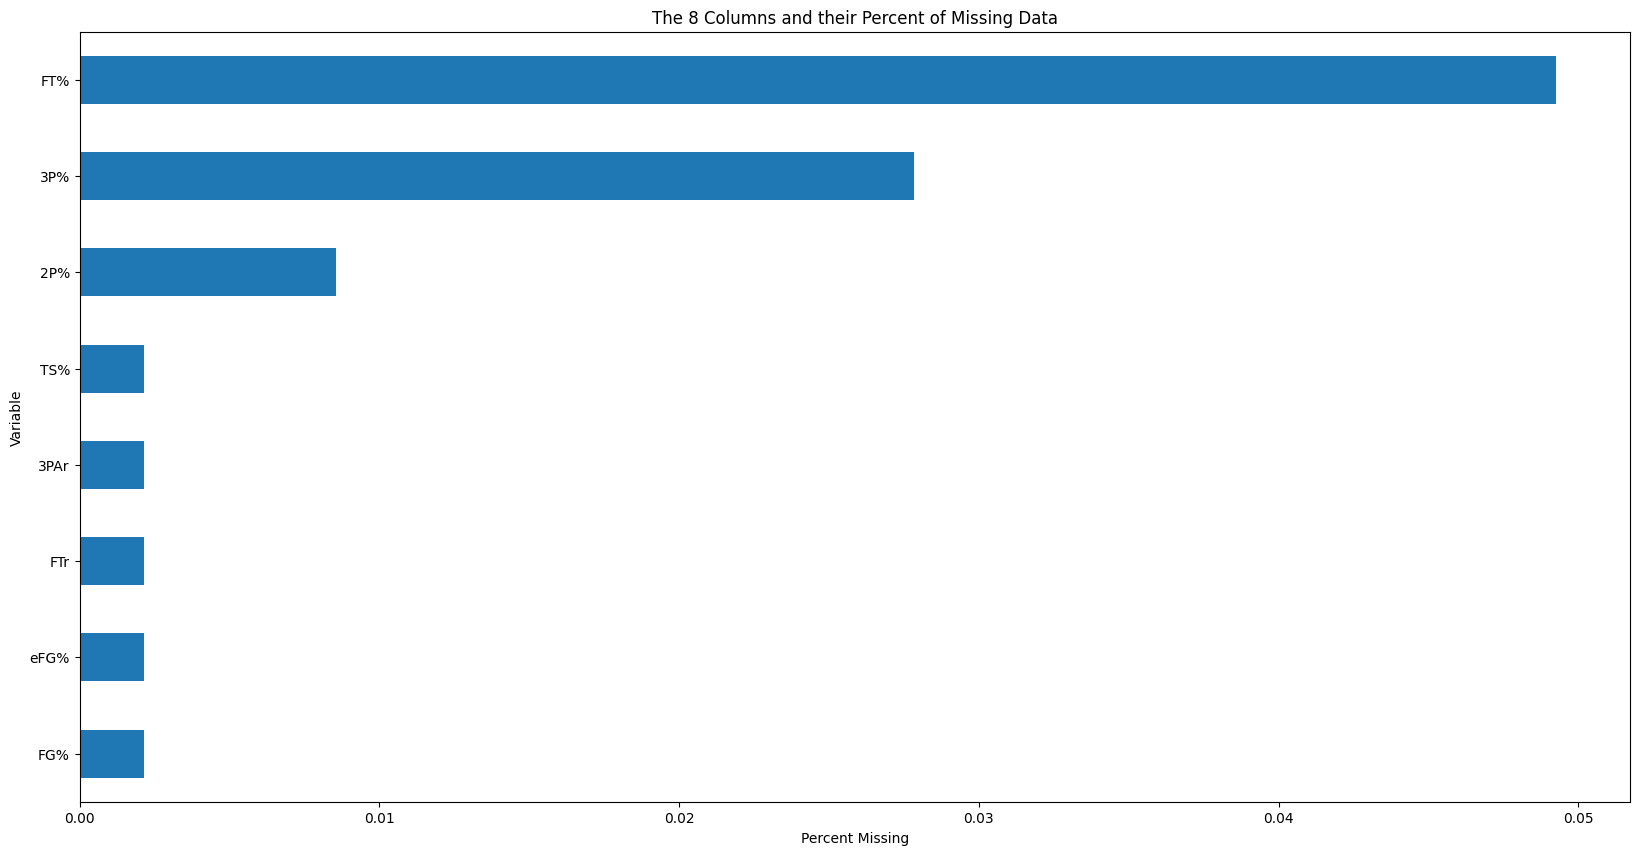

In [11]:
# visualize this in a bar graph
missing_data_df["Percent Missing"].head(8).plot(
    kind="barh", figsize=(20,10)
).invert_yaxis()
plt.xlabel("Percent Missing")
plt.ylabel("Variable")
plt.title("The 8 Columns and their Percent of Missing Data")
plt.show()

In [12]:
# fill in the missing data with 0s
# data is "missing" because player never recorded that stat during the season so we impute that data to be 0 to identify them in our model
cols_to_fill_zero = [
    "FT%",
    "3P%",
    "2P%",
    "TS%",
    "3PAr",
    "FTr",
    "eFG%",
    "FG%",
]

for col in cols_to_fill_zero:
    nba_df[col] = nba_df[col].fillna(0)


In [13]:
# show same player who had null values now has zeros in those fields
imputed_row = nba_df[nba_df["PlayerName"] == "Alondes Williams"]
imputed_row

,Id,PlayerName,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
436,436,Alondes Williams,254446,SG,23,BRK,1,0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,5,-20.9,0.0,0.0,0.0,0.0,22.0,11.2,0.0,0.0,0.0,100.0,17.7,-0.1,0.0,-0.1,-0.517,-21.3,-5.2,-26.5,0.0


### Handling outliers for better training

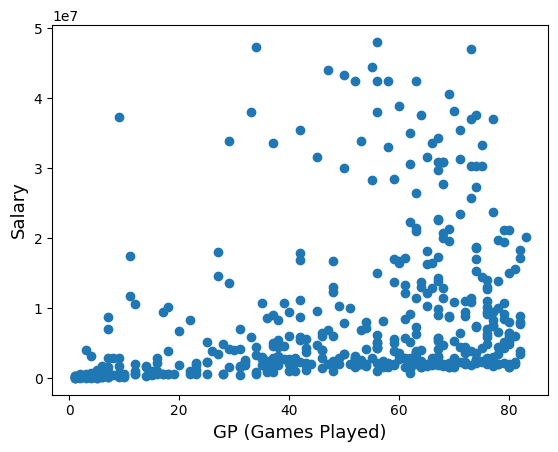

In [14]:
fig, ax = plt.subplots()
ax.scatter(x=nba_df["GP"], y=nba_df["Salary"])
plt.ylabel("Salary", fontsize=13)
plt.xlabel("GP (Games Played)", fontsize=13)
plt.show()

There seem to be some outliers where players did not play the majority of the season, yet were given large salaries. This is likely due to season ending injuries. Additionally, there are players present in the data set that were on 10-day contracts. For this reason, we will remove data from players who played in less than 20 games.

In [15]:
# drop less than 20 games
nba_df = nba_df[nba_df['GP'] >= 20]

### Normalize


 mu = 9990402.62 and sigma = 11134520.23



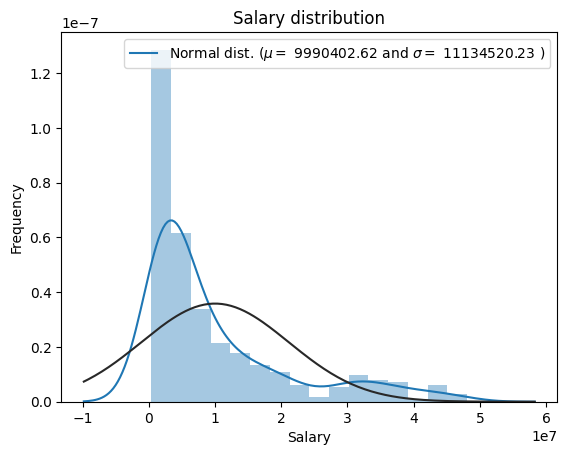

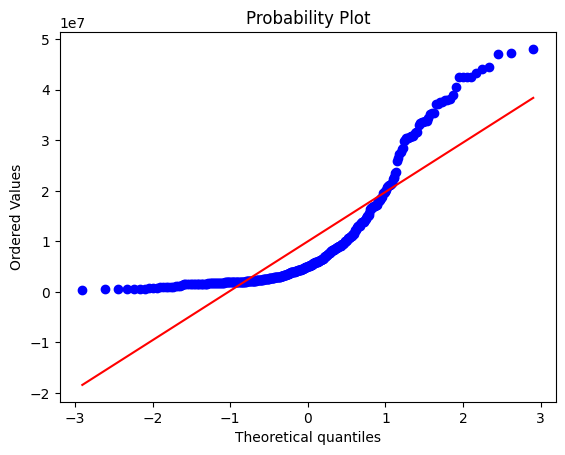

In [16]:
sns.distplot(nba_df["Salary"], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(nba_df["Salary"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best"
)
plt.ylabel("Frequency")
plt.title("Salary distribution")

# Get also the QQ-plot
fig = plt.figure()
res = probplot(nba_df["Salary"], plot=plt)
plt.show()


 mu = 15.54 and sigma = 1.09



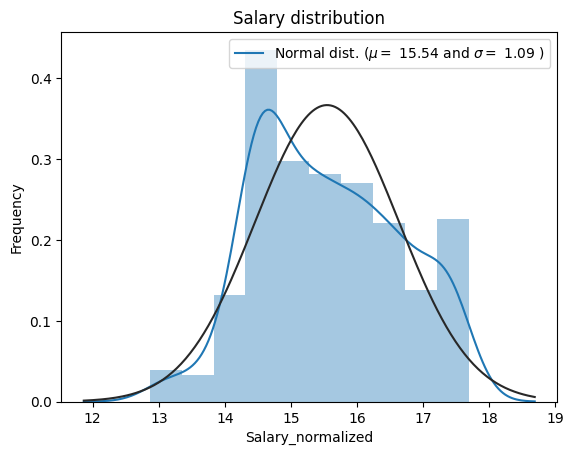

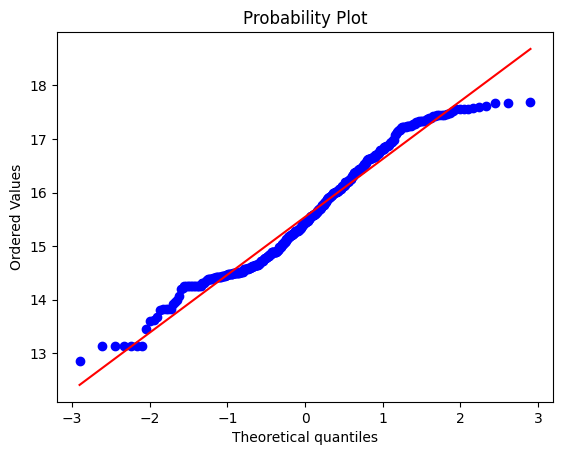

In [17]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
nba_df["Salary_normalized"] = np.log1p(nba_df["Salary"])

# Check the new distribution
sns.distplot(nba_df["Salary_normalized"], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(nba_df["Salary_normalized"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best"
)
plt.ylabel("Frequency")
plt.title("Salary distribution")

# Get also the QQ-plot
fig = plt.figure()
res = probplot(nba_df["Salary_normalized"], plot=plt)
plt.show()

## Data Analysis and Visualization

In [18]:
# scatterplot
sns.set()
cols = [
    "Salary_normalized",
    "Age",
    "MP",
    "3P",
    "TRB",
    "AST",
    "PTS",
    "PER",
    "TS%",
    "DWS",
    "VORP"
]
sns.pairplot(nba_df[cols], size=2.5)
plt.show();

In [ ]:
# Exclude non-numeric columns
numeric_df = nba_df.select_dtypes(include=[np.number])
corrmat = numeric_df.corr()

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.8, square=True);

In [ ]:
salary_correlations = corrmat['Salary_normalized']
print(salary_correlations.sort_values(ascending=False))

In [ ]:
# Visualize number of players at each position by age

plt.figure(figsize=(20,4))
sns.set_style('whitegrid')
sns.countplot(x='Age',hue='Position', data=nba_df, palette='viridis');

#### Target Variable Visualizations

In [ ]:
# boxplot to visualize the spread of salaries by each position
sns.boxplot(x='Position', y='Salary_normalized', data=nba_df, palette='rainbow');

In [ ]:
# plot to show correclation between points and salaries by position as well
# points has the highest positive correlation to salary as seen above
sns.lmplot(y='Salary', x='PTS', data=nba_df, hue='Position', palette='Set1');

Now lets compare Salary to VORP.
VORP is a box score estimate of the points per 100 team possessions that a player contributes above a replacement level player, translated to an average team and proportional to an 82 game season.

In [ ]:
sns.jointplot(x='VORP',y='Salary_normalized',data=nba_df,color='purple');

Now lets compare Salary to a defensive advanced statistic like DWS.
DWS stands for Defensive Win Shares, which is a metric in the NBA that compares a player's defensive rating to the league average.

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='DWS', y='Salary_normalized', data=nba_df, hue='Position', palette='viridis', alpha=0.6);

#### Encode categorical varibales

We will not be using the columns, PlayerName, Team, or Position, in our predictive model, as they have little to no correlation to Salary. Thus, we will bypass encoding this data to simplify data management.

#### Feature Selection

#### Step 1: Remove Highly Correlated Features
First, we calculate the correlation matrix to identify pairs of features that are highly correlated (correlation coefficient > 0.95). Highly correlated features can introduce multicollinearity, which negatively impacts model performance. We keep only one feature from each pair of highly correlated features to avoid redundancy.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# Identify the columns to exclude from feature selection
exclude_columns = ['Id', 'Salary', 'Salary_normalized']

# Get the numerical columns excluding the columns to exclude
numeric_columns = [col for col in numeric_df.columns if col not in exclude_columns]

# Create a new correlation matrix with only the relevant columns
corrmat_filtered = corrmat.loc[numeric_columns, numeric_columns]

# Find highly correlated features
corr_threshold = 0.95
correlated_features = set()

# Get the absolute correlation of each feature with 'Salary_normalized'
salary_corr = abs(corrmat['Salary_normalized'][numeric_columns])

# Iterate over the features
for feature in corrmat_filtered.columns:
    if feature not in correlated_features:
        
        # Find highly correlated features with the current feature
        correlated_cols = corrmat_filtered.columns[(abs(corrmat_filtered[feature]) > corr_threshold) & (corrmat_filtered.columns != feature)]
        
        # append correlated features to be removed
        correlated_features.update(correlated_cols)
        
# Drop the correlated features from nba_df
print("Removing features from nba_df:\n", correlated_features)
nba_df = nba_df.drop(columns=correlated_features)
numeric_df = numeric_df.drop(columns=correlated_features)
nba_df.head()


#### Step 2: Encoding Categorical Features
Next, we will encode categorical features so that our supervised model can use them for predicitons. These features are Position and Team. The position and team are likely influential on a player's salary but are represented by strings in our dataset. We will label encoding because the values of these features are within a limited range. This will give each team and position a unique numerical marker.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create label encoders
position_encoder = LabelEncoder()
team_encoder = LabelEncoder()

# Perform label encoding for 'Position' and 'Team' variables
nba_df['Position_encoded'] = position_encoder.fit_transform(nba_df['Position'])
nba_df['Team_encoded'] = team_encoder.fit_transform(nba_df['Team'])

# Drop the original 'Position' and 'Team' columns
nba_df.drop(['Position', 'Team'], axis=1, inplace=True)
nba_df.head()


In [ ]:
# # LASSO Regression for additional feature selection
# lasso = LassoCV()
# lasso.fit(numeric_df_filtered, nba_df['Salary_normalized'])

# # Use SelectFromModel to get selected features based on LASSO coefficients
# sfm = SelectFromModel(lasso, prefit=True)
# selected_features_lasso = numeric_df_filtered.columns[sfm.get_support()]

# # Convert to a DataFrame if needed
# selected_features_df = pd.DataFrame(list(selected_features_lasso), columns=['Selected_Features'])

# selected_features_df

#### Significance
By combining correlation-based feature removal with Lasso regression, we ensure that our model is trained on the most relevant features, improving its predictive power and robustness. This process is significant for predicting NBA salaries because it allows the model to focus on the key factors that truly influence player salaries, leading to more accurate and reliable predictions.

In [ ]:
# identify skewness
skewed_feats = (
    numeric_df
    .apply(lambda x: skew(x.dropna()))
    .sort_values(ascending=False)
)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({"Skew": skewed_feats})
skewness.head(20)

In [ ]:
skewness["Skew"].head(10).plot(
    kind="barh", figsize=(20, 10)
).invert_yaxis()  # top 10 skewed columns
plt.xlabel("Skew")
plt.ylabel("Variable Name")
plt.title("Top 10 Skewed Variables")
plt.show()

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print(
    "There are {} skewed numerical features to Box Cox transform (normalize)".format(
        skewness.shape[0]
    )
)

In [ ]:
negative_value_columns = numeric_df.columns[(numeric_df < 0).any()]

# Print the list of column names
print("Columns with negative values:")
print(negative_value_columns.tolist())


In [ ]:
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    # skip over columns that don't need transformation
    # skip over columns that have negative values so that they don't become NULL when transforming
    if feat not in [
        "Id",
        "Salary",
        "Salary_normalized",
        'OWS', 
        'WS', 
        'WS/48', 
        'OBPM', 
        'DBPM', 
        'BPM', 
        'VORP'
    ]:
        nba_df[feat] = boxcox1p(nba_df[feat], lam)

In [ ]:
# check that the box cot did not add any NULL values
null_columns = nba_df.columns[nba_df.isnull().any()]
null_count = nba_df[null_columns].isnull().sum()

print("Column Name: NULL Count")
for i in range(0, len(null_columns)):
    print(f"{null_columns[i]}: {null_count[i]}")

## Data Analytics

All of our data is labled therefore we will be implementing supervised learning methods

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV

In [ ]:
def train_and_compute_rmse(df, model):
    # Splitting the data into train and test set  
    X = df.drop(columns=['Salary', 'Id', 'PlayerName', 'Salary_normalized'])
    y = df['Salary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Training the model
    model.fit(X_train, np.log1p(y_train))
    
    # Making predictions on the test set
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    if (
            np.isnan(y_pred).any()
            or np.isinf(y_pred).any()
        ):
            print(
                f"Warning: NaN or infinity values found in predictions or true values. Imputing 0 for problematic values in y_pred."
            )
            y_pred[np.isnan(y_pred) | np.isinf(y_pred)] = 0

    # Computing RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

In [ ]:
def compute_rmse_std(df, model):
    rmse_list = []
    for i in range(30):
        rmse_list.append(train_and_compute_rmse(df, model))

    mean = np.mean(rmse_list)
    std = np.std(rmse_list)

    return mean, std

In [ ]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.1)

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=10)

In [ ]:
rf = RandomForestRegressor(n_estimators=500)

In [ ]:
dt = DecisionTreeRegressor(max_depth=10)

In [ ]:
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [ ]:
model_lgb = lgb.LGBMRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [ ]:
nba_df.head()

In [ ]:
#Get the avg rmse and std over 30 tests for each model
lr_no_int_list = compute_rmse_std(nba_df, lr_no_int)
lr_w_int_list = compute_rmse_std(nba_df, lr_w_int)
elastic_net_list = compute_rmse_std(nba_df, elastic_net)
#neigh_list = compute_rmse_std(nba_df, neigh)
dt_list = compute_rmse_std(nba_df, dt)
rf_list = compute_rmse_std(nba_df, rf)
model_xgb_list = compute_rmse_std(nba_df, model_xgb)

# plot RMSE and STD for each Algorithm
data = {
    "Linear (No Intercept)": lr_no_int_list,
    "Linear (w/ Intercept)": lr_w_int_list,
    "Elastic Net": elastic_net_list,
    #"Nearest Neighbor": neigh_list,
    "Decision Tree": dt_list,
    "Random Forest": rf_list,
    "XGBoost": model_xgb_list,
}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by=[0], ascending=True)
data_df.columns = ["Algorithm", "RMSE", "STD"]

In [ ]:
# creating the bar plot
data_df.plot(kind="bar", x="Algorithm", y=["RMSE", "STD"], figsize=(20, 10), rot=0)
plt.xlabel("Algorithm", fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation", fontsize=20)
plt.show()

In [ ]:
def hyperparameter_tune_bayesian(X_train, y_train, regressor):
    """
    Perform hyperparameter tuning for XGBoost or LightGBM using Bayesian search.

    Parameters:
    - X_train: pandas DataFrame
        Training features.
    - y_train: pandas Series
        Training target variable.
    - regressor_type: str
        Type of regressor to tune ('xgboost' or 'lightgbm').

    Returns:
    - best_params: dict
        Best hyperparameters found during tuning.
    """
    # Define the common parameter space for both XGBoost and LightGBM
    param_space_common = {
        "n_estimators": (100, 1200),
        "learning_rate": (0.01, 0.2, "log-uniform"),
        "max_depth": (3, 10),
    }

    regressor_type = regressor.lower()
    if regressor_type == "xgboost":
        regressor = xgb.XGBRegressor()
    elif regressor_type == "lightgbm":
        regressor = lgb.LGBMRegressor()
    else:
        raise ValueError("Unsupported regressor type. Choose 'xgboost' or 'lightgbm'.")

    # Update the search space with common parameters
    param_space = param_space_common.copy()

    # Perform Bayesian search
    bayes_search = BayesSearchCV(
        estimator=regressor,
        search_spaces=param_space,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,  # Set the number of parallel jobs
    )
    bayes_search.fit(X_train, np.log1p(y_train))

    # Get the best hyperparameters
    best_params = bayes_search.best_params_

    return best_params

In [ ]:
def k_fold_regression(
    data,
    regressor,
    target_column="Salary",
    cols_to_ignore=['Salary', 'Id', 'PlayerName', 'Salary_normalized'],
    n_splits=5,
    tune_hyperparameters=False,
):
    rmse_scores = []
    train_sizes = []
    test_sizes = []

    # Prepare the feature matrix X and target vector y
    X = data.drop(columns=cols_to_ignore)
    y = data[target_column]

    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Cross-validation process
    for train_index, val_index in kf.split(X):
        if (
            isinstance(regressor, (xgb.XGBRegressor, lgb.LGBMRegressor))
            and tune_hyperparameters
        ):
            if isinstance(regressor, xgb.XGBRegressor):
                regressor_type = "xgboost"
            elif isinstance(regressor, lgb.LGBMRegressor):
                regressor_type = "lightgbm"
            else:
                raise ValueError(
                    "Unsupported regressor type. Supported types: XGBRegressor, LGBMRegressor"
                )

            # Use the entire training data for hyperparameter tuning
            best_params = hyperparameter_tune_bayesian(X, y, regressor_type)
            print(f"Best hyperparameters for {regressor_type} Fold: {best_params}")
            regressor.set_params(**best_params)

        # Split into training and validation folds
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Fit the model on the training fold
        regressor.fit(X_train_fold, np.log1p(y_train_fold))  # Fit on log-transformed target
        y_pred_log_fold = regressor.predict(X_val_fold)
        y_pred_fold = np.expm1(y_pred_log_fold)  # Convert back to original scale

        # Calculate RMSE for the validation fold
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        rmse_scores.append(rmse)
        train_sizes.append(len(y_train_fold))
        test_sizes.append(len(y_val_fold))

    return rmse_scores, train_sizes, test_sizes

In [ ]:
def compute_rmse_std_k_fold(df, model, tune_hyper=False):
    rmse_list = []
        
    rmse_list.append(k_fold_regression(df, model, tune_hyperparameters=tune_hyper))

    mean = np.mean(rmse_list)
    std = np.std(rmse_list)

    return mean, std

In [ ]:
def print_rmse_k_fold(data, regressor, target_column="Salary", cols_to_ignore=['Salary', 'Id', 'PlayerName', 'Salary_normalized'], n_splits=5, tune_hyperparameters=False):
    rmse_scores, train_sizes, test_sizes = k_fold_regression(
        data, regressor, target_column, cols_to_ignore, n_splits, tune_hyperparameters
    )

    for fold, (rmse, train_size, test_size) in enumerate(zip(rmse_scores, train_sizes, test_sizes)):
        print(f"Fold {fold + 1} RMSE: {rmse:.4f}, Train Size: {train_size}, Test Size: {test_size}")

    overall_rmse = np.mean(rmse_scores)
    print(f"Overall RMSE: {overall_rmse:.4f}")

In [ ]:
#Get the avg rmse and std over 30 tests for each model
lr_no_int_list = compute_rmse_std_k_fold(nba_df, lr_no_int)
lr_w_int_list = compute_rmse_std_k_fold(nba_df, lr_w_int)
elastic_net_list = compute_rmse_std_k_fold(nba_df, elastic_net)
#neigh_list = compute_rmse_std_k_fold(nba_df, neigh)
dt_list = compute_rmse_std_k_fold(nba_df, dt)
rf_list = compute_rmse_std_k_fold(nba_df, rf)
model_xgb_list = compute_rmse_std_k_fold(nba_df, model_xgb)

#The next line takes a while (Roughly 10 mins), If want to quickly run, comment out this line and the line below in data
# model_xgb_hyper_list = compute_rmse_std_k_fold(nba_df, model_xgb, tune_hyper=True)

# plot RMSE and STD for each Algorithm
data = {
    "Linear (No Intercept)": lr_no_int_list,
    "Linear (w/ Intercept)": lr_w_int_list,
    "Elastic Net": elastic_net_list,
    #"Nearest Neighbor": neigh_list,
    "Decision Tree": dt_list,
    "Random Forest": rf_list,
    "XGBoost": model_xgb_list,

    #Comment below if want to run quicker
    # "XGBoost Hyper": model_xgb_hyper_list,
}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by=[0], ascending=True)
data_df.columns = ["Algorithm", "RMSE", "STD"]

In [ ]:
# creating the bar plot
data_df.plot(kind="bar", x="Algorithm", y=["RMSE", "STD"], figsize=(20, 10), rot=0)
plt.xlabel("Algorithm", fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation", fontsize=20)
plt.show()

### Meta Model

In [ ]:
from sklearn.ensemble import StackingRegressor

# first stacking model
  
estimators = [
   ('elastic_net', elastic_net),
   ('rf', rf),
   ('lr_w_int', lr_w_int)
]


sr = StackingRegressor(
   estimators=estimators,
   final_estimator=model_xgb
)

In [ ]:
from sklearn.ensemble import VotingRegressor

# voting stacking model, putting weights on different models

vr = VotingRegressor([
   ('rf', rf),
   ('model_xgb', model_xgb),
   ('elastic_net', elastic_net),
   ('lr_w_int', lr_w_int)
  
], weights=[1,1,2,2])


In [ ]:
estimators2 = [
   ('elastic_net', elastic_net),
   ('model_xgb', model_xgb),
   ('lr_w_int', lr_w_int),
   ('rf', rf)
]

# using the voting model as our final estimator

sr2 = StackingRegressor(
   estimators=estimators2,
   final_estimator=vr
)

# More tesing with the new models
Removed Nearest Neighbor, Linear No Int, Linear W Int, Elastic Net, and Descision tree because they are worst performing

In [ ]:
#Get the avg rmse and std over 30 tests for each model
rf_list = compute_rmse_std_k_fold(nba_df, rf)
model_xgb_list = compute_rmse_std_k_fold(nba_df, model_xgb)
sr_list = compute_rmse_std_k_fold(nba_df, sr)
vr_list = compute_rmse_std_k_fold(nba_df, vr)
sr2_list = compute_rmse_std_k_fold(nba_df, sr2)
# model_xgb_hyper_list = compute_rmse_std_k_fold(nba_df, model_xgb, tune_hyper=True)
sr_hyper_list = compute_rmse_std_k_fold(nba_df, sr, tune_hyper=True)
vr_hyper_list = compute_rmse_std_k_fold(nba_df, vr, tune_hyper=True)
sr2_hyper_list = compute_rmse_std_k_fold(nba_df, sr2, tune_hyper=True)


# plot RMSE and STD for each Algorithm
data = {
    "Random Forest": rf_list,
    "XGBoost": model_xgb_list,
    "Stacking Regressor": sr_list,
    "Voting Regressor": vr_list,
    "Stacking Regressor 2": sr2_list,
    # "XGBoost Hyper": model_xgb_hyper_list,
    "Stacking Regressor Hyper": sr_hyper_list,
    "Voting Regressor Hyper": vr_hyper_list,
    "Stacking Regressor 2 Hyper": sr2_hyper_list,
}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by=[0], ascending=True)
data_df.columns = ["Algorithm", "RMSE", "STD"]

In [ ]:
# creating the bar plot
data_df.plot(kind="bar", x="Algorithm", y=["RMSE", "STD"], figsize=(20, 10), rot=0)
plt.xlabel("Algorithm", fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation", fontsize=20)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Prepare the data
X = nba_df.drop(columns=['Salary', 'Id', 'PlayerName', 'Salary_normalized'])
y = nba_df['Salary']

# Initialize the regressor
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

# Initialize KFold cross-validator
kf = KFold(n_splits=5, shuffle=True)

rmse_scores = []
all_actuals = []
all_predictions = []

# K-fold cross-validation process
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training the model
    model_xgb.fit(X_train, np.log1p(y_train))

    # Making predictions on the test set
    y_pred_log = model_xgb.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    # Handle NaN or infinity values in predictions
    if np.isnan(y_pred).any() or np.isinf(y_pred).any():
        print("Warning: NaN or infinity values found in predictions. Imputing 0 for problematic values in y_pred.")
        y_pred[np.isnan(y_pred) | np.isinf(y_pred)] = 0

    # Collect actual and predicted values
    all_actuals.extend(y_test)
    all_predictions.extend(y_pred)

    # Computing RMSE for the current fold
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Convert collected actual and predicted values to a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual Salary': all_actuals, 'Predicted Salary': all_predictions})
print(comparison_df)

# Print average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print(f"Average RMSE: {average_rmse}")